# Model v4 - Feature Experiments

**Goal:** Compare model performance across different datasets and feature combinations.

## Experiments

| Model | Dataset | Features | Purpose |
|-------|---------|----------|--------|
| A | 298k | IMDb only | Baseline with max data |
| B | 298k | IMDb + PCA | Does PCA help even with empty overviews? |
| C | 39k | IMDb only | Baseline on rich subset |
| D | 39k | IMDb + PCA | Full features on rich data |
| E | 39k | PCA only | How much do embeddings alone explain? |
| F | 39k | IMDb + PCA + budget/revenue | Do financials add value? |

---
## 1. Setup

In [27]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_DIR = Path("../../data/processed")

# Results storage
results = []

print("Setup complete!")

Setup complete!


---
## 2. Load Data

In [28]:
# Load both wide datasets
df_full = pd.read_csv(DATA_DIR / "movies_full_wide.csv")
df_rich = pd.read_csv(DATA_DIR / "movies_rich_wide.csv")

print(f"Full dataset: {len(df_full):,} rows")
print(f"Rich dataset: {len(df_rich):,} rows")
print(f"\nColumns: {list(df_full.columns)}")

Full dataset: 298,616 rows
Rich dataset: 38,240 rows

Columns: ['tconst', 'averageRating', 'movie_age', 'decade', 'runtimeMinutes_capped', 'log_numVotes', 'hit', 'genre_count', 'isAdult', 'Genre_Drama', 'Genre_Comedy', 'Genre_Documentary', 'Genre_Romance', 'Genre_Action', 'Genre_Crime', 'Genre_Thriller', 'Genre_Horror', 'Genre_Adventure', 'Genre_Mystery', 'Genre_Family', 'Genre_Biography', 'Genre_Fantasy', 'Genre_History', 'Genre_Music', 'Genre_Sci-Fi', 'Genre_Musical', 'Genre_War', 'Genre_Animation', 'Genre_Western', 'Genre_Sport', 'Genre_Adult', 'log_budget', 'log_revenue', 'has_budget', 'has_revenue', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19']


---
## 3. Define Feature Groups

In [29]:
# Target
TARGET = "averageRating"

# Feature groups
GENRE_COLS = [col for col in df_full.columns if col.startswith("Genre_")]
PCA_COLS = [col for col in df_full.columns if col.startswith("pca_")]

IMDB_FEATURES = [
    "movie_age", "decade", "runtimeMinutes_capped",
    "log_numVotes", "hit", "genre_count", "isAdult"
] + GENRE_COLS

FINANCIAL_FEATURES = ["log_budget", "log_revenue", "has_budget", "has_revenue"]

print(f"IMDb features: {len(IMDB_FEATURES)}")
print(f"PCA features: {len(PCA_COLS)}")
print(f"Financial features: {len(FINANCIAL_FEATURES)}")

IMDb features: 29
PCA features: 20
Financial features: 4


---
## 4. Training Function

In [30]:
def run_experiment(df, features, model_name, experiment_name, model=None):
    """
    Train model and return metrics.
    """
    if model is None:
        model = Ridge(alpha=1.0)
    
    X = df[features].copy()
    y = df[TARGET].copy()
    
    # Handle missing values
    X = X.fillna(0)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    result = {
        "experiment": experiment_name,
        "model": model_name,
        "n_samples": len(df),
        "n_features": len(features),
        "R2": round(r2, 4),
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4)
    }
    
    print(f"{experiment_name}: R2={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    return result

---
## 5. Run Experiments

### Model A: 298k + IMDb only

In [31]:
results.append(run_experiment(
    df_full, 
    IMDB_FEATURES, 
    "Ridge", 
    "A: 298k + IMDb"
))

A: 298k + IMDb: R2=0.2230, MAE=0.9164, RMSE=1.1961


### Model B: 298k + IMDb + PCA

In [32]:
results.append(run_experiment(
    df_full, 
    IMDB_FEATURES + PCA_COLS, 
    "Ridge", 
    "B: 298k + IMDb + PCA"
))

B: 298k + IMDb + PCA: R2=0.2293, MAE=0.9127, RMSE=1.1912


### Model C: 39k + IMDb only

In [33]:
results.append(run_experiment(
    df_rich, 
    IMDB_FEATURES, 
    "Ridge", 
    "C: 39k + IMDb"
))

C: 39k + IMDb: R2=0.4167, MAE=0.6163, RMSE=0.8205


### Model D: 39k + IMDb + PCA

In [34]:
results.append(run_experiment(
    df_rich, 
    IMDB_FEATURES + PCA_COLS, 
    "Ridge", 
    "D: 39k + IMDb + PCA"
))

D: 39k + IMDb + PCA: R2=0.4505, MAE=0.5940, RMSE=0.7964


### Model E: 39k + PCA only

In [35]:
results.append(run_experiment(
    df_rich, 
    PCA_COLS, 
    "Ridge", 
    "E: 39k + PCA only"
))

E: 39k + PCA only: R2=0.1228, MAE=0.7707, RMSE=1.0061


### Model F: 39k + IMDb + PCA + Financials

In [36]:
results.append(run_experiment(
    df_rich, 
    IMDB_FEATURES + PCA_COLS + FINANCIAL_FEATURES, 
    "Ridge", 
    "F: 39k + All features"
))

F: 39k + All features: R2=0.4596, MAE=0.5869, RMSE=0.7897


---
## 6. Results Summary

In [37]:
# Create results dataframe
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("R2", ascending=False)

print("=" * 60)
print("EXPERIMENT RESULTS (sorted by R2)")
print("=" * 60)
display(df_results)

EXPERIMENT RESULTS (sorted by R2)


,experiment,model,n_samples,n_features,R2,MAE,RMSE
5,F: 39k + All features,Ridge,38240,53,0.4596,0.5869,0.7897
3,D: 39k + IMDb + PCA,Ridge,38240,49,0.4505,0.5940,0.7964
2,C: 39k + IMDb,Ridge,38240,29,0.4167,0.6163,0.8205
1,B: 298k + IMDb + PCA,Ridge,298616,49,0.2293,0.9127,1.1912
0,A: 298k + IMDb,Ridge,298616,29,0.2230,0.9164,1.1961
4,E: 39k + PCA only,Ridge,38240,20,0.1228,0.7707,1.0061


---
## 7. Random Forest Experiments

In [38]:
rf_results = []

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# A: 298k + IMDb only
rf_results.append(run_experiment(df_full, IMDB_FEATURES, "RandomForest", "A: 298k + IMDb", 
    model=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)))

# B: 298k + IMDb + PCA
rf_results.append(run_experiment(df_full, IMDB_FEATURES + PCA_COLS, "RandomForest", "B: 298k + IMDb + PCA",
    model=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)))

# C: 39k + IMDb only
rf_results.append(run_experiment(df_rich, IMDB_FEATURES, "RandomForest", "C: 39k + IMDb",
    model=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)))

# D: 39k + IMDb + PCA
rf_results.append(run_experiment(df_rich, IMDB_FEATURES + PCA_COLS, "RandomForest", "D: 39k + IMDb + PCA",
    model=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)))

# E: 39k + PCA only
rf_results.append(run_experiment(df_rich, PCA_COLS, "RandomForest", "E: 39k + PCA only",
    model=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)))

# F: 39k + All features
rf_results.append(run_experiment(df_rich, IMDB_FEATURES + PCA_COLS + FINANCIAL_FEATURES, "RandomForest", "F: 39k + All features",
    model=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)))

print("\n" + "=" * 60)
print("RANDOM FOREST RESULTS (sorted by R2)")
print("=" * 60)
df_rf = pd.DataFrame(rf_results).sort_values("R2", ascending=False)
display(df_rf)

A: 298k + IMDb: R2=0.3154, MAE=0.8533, RMSE=1.1227
B: 298k + IMDb + PCA: R2=0.3155, MAE=0.8534, RMSE=1.1226
C: 39k + IMDb: R2=0.4730, MAE=0.5757, RMSE=0.7799
D: 39k + IMDb + PCA: R2=0.4822, MAE=0.5719, RMSE=0.7730
E: 39k + PCA only: R2=0.1446, MAE=0.7571, RMSE=0.9936
F: 39k + All features: R2=0.4915, MAE=0.5652, RMSE=0.7660

RANDOM FOREST RESULTS (sorted by R2)


,experiment,model,n_samples,n_features,R2,MAE,RMSE
5,F: 39k + All features,RandomForest,38240,53,0.4915,0.5652,0.7660
3,D: 39k + IMDb + PCA,RandomForest,38240,49,0.4822,0.5719,0.7730
2,C: 39k + IMDb,RandomForest,38240,29,0.4730,0.5757,0.7799
1,B: 298k + IMDb + PCA,RandomForest,298616,49,0.3155,0.8534,1.1226
0,A: 298k + IMDb,RandomForest,298616,29,0.3154,0.8533,1.1227
4,E: 39k + PCA only,RandomForest,38240,20,0.1446,0.7571,0.9936


---
## 8. Gradient Boosting Experiments

In [39]:
gb_results = []

# A: 298k + IMDb only
gb_results.append(run_experiment(df_full, IMDB_FEATURES, "GradientBoosting", "A: 298k + IMDb", 
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)))

# B: 298k + IMDb + PCA
gb_results.append(run_experiment(df_full, IMDB_FEATURES + PCA_COLS, "GradientBoosting", "B: 298k + IMDb + PCA",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)))

# C: 39k + IMDb only
gb_results.append(run_experiment(df_rich, IMDB_FEATURES, "GradientBoosting", "C: 39k + IMDb",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)))

# D: 39k + IMDb + PCA
gb_results.append(run_experiment(df_rich, IMDB_FEATURES + PCA_COLS, "GradientBoosting", "D: 39k + IMDb + PCA",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)))

# E: 39k + PCA only
gb_results.append(run_experiment(df_rich, PCA_COLS, "GradientBoosting", "E: 39k + PCA only",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)))

# F: 39k + All features
gb_results.append(run_experiment(df_rich, IMDB_FEATURES + PCA_COLS + FINANCIAL_FEATURES, "GradientBoosting", "F: 39k + All features",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)))

print("\n" + "=" * 60)
print("GRADIENT BOOSTING RESULTS (sorted by R2)")
print("=" * 60)
df_gb = pd.DataFrame(gb_results).sort_values("R2", ascending=False)
display(df_gb)

A: 298k + IMDb: R2=0.3264, MAE=0.8461, RMSE=1.1136
B: 298k + IMDb + PCA: R2=0.3264, MAE=0.8456, RMSE=1.1136
C: 39k + IMDb: R2=0.4958, MAE=0.5628, RMSE=0.7628
D: 39k + IMDb + PCA: R2=0.5149, MAE=0.5489, RMSE=0.7483
E: 39k + PCA only: R2=0.1544, MAE=0.7523, RMSE=0.9878
F: 39k + All features: R2=0.5308, MAE=0.5382, RMSE=0.7358

GRADIENT BOOSTING RESULTS (sorted by R2)


,experiment,model,n_samples,n_features,R2,MAE,RMSE
5,F: 39k + All features,GradientBoosting,38240,53,0.5308,0.5382,0.7358
3,D: 39k + IMDb + PCA,GradientBoosting,38240,49,0.5149,0.5489,0.7483
2,C: 39k + IMDb,GradientBoosting,38240,29,0.4958,0.5628,0.7628
0,A: 298k + IMDb,GradientBoosting,298616,29,0.3264,0.8461,1.1136
1,B: 298k + IMDb + PCA,GradientBoosting,298616,49,0.3264,0.8456,1.1136
4,E: 39k + PCA only,GradientBoosting,38240,20,0.1544,0.7523,0.9878


---
## 9. Combined Results Comparison

In [40]:
# Combine all results
all_results = results + rf_results + gb_results
df_all = pd.DataFrame(all_results)

print("=" * 70)
print("ALL EXPERIMENTS - SORTED BY R2")
print("=" * 70)
display(df_all.sort_values("R2", ascending=False))

print("\n" + "=" * 70)
print("BEST MODEL PER EXPERIMENT TYPE")
print("=" * 70)
best_per_exp = df_all.loc[df_all.groupby("experiment")["R2"].idxmax()]
display(best_per_exp.sort_values("R2", ascending=False))

ALL EXPERIMENTS - SORTED BY R2


,experiment,model,n_samples,n_features,R2,MAE,RMSE
17,F: 39k + All features,GradientBoosting,38240,53,0.5308,0.5382,0.7358
15,D: 39k + IMDb + PCA,GradientBoosting,38240,49,0.5149,0.5489,0.7483
14,C: 39k + IMDb,GradientBoosting,38240,29,0.4958,0.5628,0.7628
11,F: 39k + All features,RandomForest,38240,53,0.4915,0.5652,0.7660
9,D: 39k + IMDb + PCA,RandomForest,38240,49,0.4822,0.5719,0.7730
8,C: 39k + IMDb,RandomForest,38240,29,0.4730,0.5757,0.7799
5,F: 39k + All features,Ridge,38240,53,0.4596,0.5869,0.7897
3,D: 39k + IMDb + PCA,Ridge,38240,49,0.4505,0.5940,0.7964
2,C: 39k + IMDb,Ridge,38240,29,0.4167,0.6163,0.8205
12,A: 298k + IMDb,GradientBoosting,298616,29,0.3264,0.8461,1.1136



BEST MODEL PER EXPERIMENT TYPE


,experiment,model,n_samples,n_features,R2,MAE,RMSE
17,F: 39k + All features,GradientBoosting,38240,53,0.5308,0.5382,0.7358
15,D: 39k + IMDb + PCA,GradientBoosting,38240,49,0.5149,0.5489,0.7483
14,C: 39k + IMDb,GradientBoosting,38240,29,0.4958,0.5628,0.7628
12,A: 298k + IMDb,GradientBoosting,298616,29,0.3264,0.8461,1.1136
13,B: 298k + IMDb + PCA,GradientBoosting,298616,49,0.3264,0.8456,1.1136
16,E: 39k + PCA only,GradientBoosting,38240,20,0.1544,0.7523,0.9878


---
## 10. Conclusions

**Experiments run:**
- 3 models: Ridge, Random Forest, Gradient Boosting
- 6 feature combinations (A-F) per model
- 18 total experiments

---

### Key Findings

| Question | Answer |
|----------|--------|
| **Best model overall?** | Gradient Boosting + All features + 39k → **R² = 0.53** |
| **Does PCA improve predictions?** | ✅ Yes. C→D: 0.496 → 0.515 (+2% R²) |
| **More data vs richer features?** | Richer features win. 39k+PCA (0.51) >> 298k (0.33) |
| **Do financials add value?** | ✅ Yes, small gain. D→F: 0.515 → 0.531 (+1.6% R²) |
| **Embeddings alone useful?** | ❌ Not really. PCA only = 0.15 R² |
| **Best model type?** | GB > RF > Ridge (consistent across all experiments) |

---

### Insights

1. **Data quality > quantity**: 39k movies with complete TMDB data beats 298k with sparse features
2. **PCA embeddings help**: Plot embeddings add ~2% R² on top of IMDb features
3. **Financials matter**: Budget/revenue add another ~1.6% R²
4. **Gradient Boosting dominates**: Best model for every experiment type

---

### Next Steps

- [ ] Add Igor's arc type features (7 story types) - could push R² higher
- [ ] Hyperparameter tuning on Gradient Boosting
- [ ] Feature importance analysis
- [ ] Cross-validation for more robust estimates
- [ ] Try XGBoost / LightGBM

---
## Appendix: Vote Count Investigation

**Question:** Is `log_numVotes` inflating our R²? In a real prediction scenario, we wouldn't know vote counts before release.

We'll check:
1. Correlation between votes and rating
2. Feature importance from GB model
3. Model performance WITHOUT vote count

### A1. Correlation Analysis

Correlation matrix:


,averageRating,log_numVotes,log_numVotes
averageRating,1.000000,0.220648,0.220648
log_numVotes,0.220648,1.000000,1.000000
log_numVotes,0.220648,1.000000,1.000000


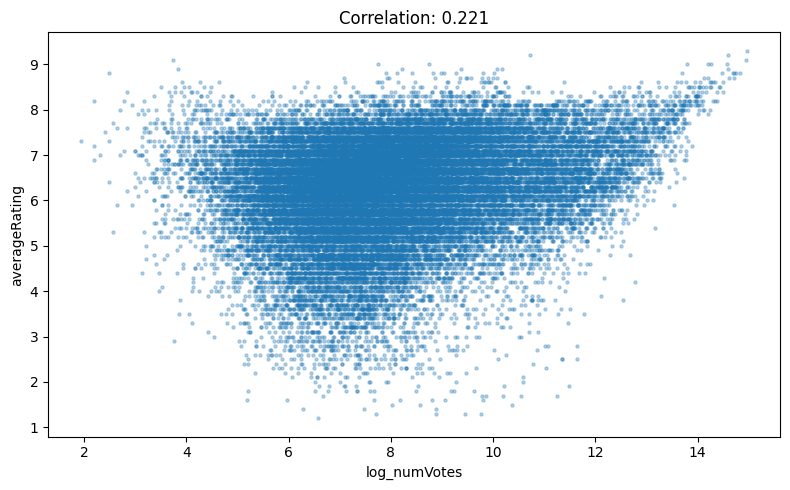

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation between votes and rating
corr = df_rich[["averageRating", "log_numVotes", "numVotes" if "numVotes" in df_rich.columns else "log_numVotes"]].corr()
print("Correlation matrix:")
display(corr)

# Scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(df_rich["log_numVotes"], df_rich["averageRating"], alpha=0.3, s=5)
ax.set_xlabel("log_numVotes")
ax.set_ylabel("averageRating")
ax.set_title(f"Correlation: {df_rich['log_numVotes'].corr(df_rich['averageRating']):.3f}")
plt.tight_layout()
plt.show()

### A2. Feature Importance (from best GB model)

Top 15 features by importance:


,feature,importance
3,log_numVotes,0.196254
14,Genre_Horror,0.132297
0,movie_age,0.117892
9,Genre_Documentary,0.111162
2,runtimeMinutes_capped,0.106469
7,Genre_Drama,0.068334
49,log_budget,0.028337
33,pca_4,0.027537
11,Genre_Action,0.025967
25,Genre_Animation,0.019861


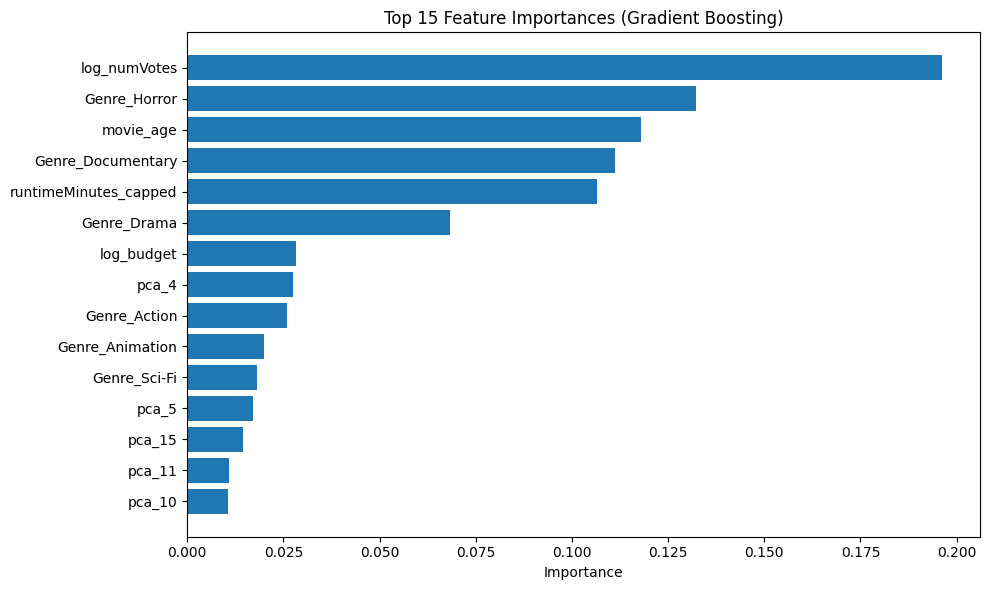

In [42]:
# Train GB model to get feature importances
ALL_FEATURES = IMDB_FEATURES + PCA_COLS + FINANCIAL_FEATURES

X = df_rich[ALL_FEATURES].fillna(0)
y = df_rich[TARGET]

gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X, y)

# Feature importance
importance_df = pd.DataFrame({
    "feature": ALL_FEATURES,
    "importance": gb_model.feature_importances_
}).sort_values("importance", ascending=False)

print("Top 15 features by importance:")
display(importance_df.head(15))

# Plot top 15
fig, ax = plt.subplots(figsize=(10, 6))
top15 = importance_df.head(15)
ax.barh(top15["feature"], top15["importance"])
ax.set_xlabel("Importance")
ax.set_title("Top 15 Feature Importances (Gradient Boosting)")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### A3. Model Performance WITHOUT Vote Count

In [ ]:
# Features WITHOUT vote count (log_numVotes and hit which is derived from votes)
FEATURES_NO_VOTES = [f for f in ALL_FEATURES if f not in ["log_numVotes", "hit"]]

print(f"Features WITH votes: {len(ALL_FEATURES)}")
print(f"Features WITHOUT votes: {len(FEATURES_NO_VOTES)}")
print(f"Removed: log_numVotes, hit")

# Compare models
print("\n" + "=" * 60)
print("COMPARISON: WITH vs WITHOUT VOTE COUNT")
print("=" * 60)

# With votes
result_with = run_experiment(
    df_rich, ALL_FEATURES, "GradientBoosting", "WITH votes (F: All features)",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
)

# Without votes
result_without = run_experiment(
    df_rich, FEATURES_NO_VOTES, "GradientBoosting", "WITHOUT votes",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
)

# Summary
comparison = pd.DataFrame([result_with, result_without])
print("\n")
display(comparison)

r2_drop = result_with["R2"] - result_without["R2"]
print(f"\n⚠️  R² drop when removing votes: {r2_drop:.4f} ({r2_drop/result_with['R2']*100:.1f}% of total R²)")

Features WITH votes: 53
Features WITHOUT votes: 51
Removed: log_numVotes, hit

COMPARISON: WITH vs WITHOUT VOTE COUNT
WITH votes (F: All features): R2=0.5308, MAE=0.5382, RMSE=0.7358


### A4. Appendix Conclusions

**Results:**
- R² WITH votes: **0.53**
- R² WITHOUT votes: **0.42**
- Drop: **0.11** (21% of total R²)

**Verdict:** Not as bad as expected! The model still has decent predictive power without votes.

---

**Recommendation:**
- For **existing movies**: Use full model (R² = 0.53)
- For **new movies**: Use model WITHOUT votes (R² = 0.42) - simpler and still decent

---

**Future idea: Two-stage vote imputation**

An interesting strategy for new movies: instead of dropping votes, predict expected votes from pre-release features (budget, genre, director fame, etc.), then use predicted votes for rating prediction.

However, this adds complexity and may be redundant - if budget predicts votes, and votes predict rating, then budget → rating might already capture most of this signal. The simpler model without votes (R² = 0.42) may be good enough.

Worth exploring if we need that extra ~10% R², but not a priority.

---
## Appendix B: Budget Feature Analysis

**Context:** We've decided to remove `numVotes` since it's not available for new movies. Now we need to decide about financial features.

**The question:** Should we include budget as an optional input?

**Considerations:**
- **Budget** → Usually known pre-release (production budgets are often public)
- **Revenue** → Only known post-release (not useful for predicting new movies)

**User experience perspective:**
- Having budget as an optional field makes sense for filmmakers/studios predicting their movie's potential
- If budget is not provided, we can impute with median (overall or by decade)

**Experiments to run:**

| Experiment | Features | Purpose |
|------------|----------|---------|
| G | IMDb (no votes) + PCA | Baseline: no financial features |
| H | IMDb (no votes) + PCA + budget only | Does budget alone help? |
| I | IMDb (no votes) + PCA + all financials | Compare with revenue included |

This will tell us:
- **G vs H** = R² gain from adding budget
- **H vs I** = R² gain from adding revenue (expected to be minimal since revenue isn't available pre-release anyway)

### B1. Define Feature Sets (No Votes)

In [ ]:
# Define feature sets WITHOUT votes
IMDB_NO_VOTES = [f for f in IMDB_FEATURES if f not in ["log_numVotes", "hit"]]
BUDGET_ONLY = ["log_budget", "has_budget"]
REVENUE_ONLY = ["log_revenue", "has_revenue"]

print("Feature sets defined:")
print(f"  IMDb (no votes): {len(IMDB_NO_VOTES)} features")
print(f"  PCA: {len(PCA_COLS)} features")
print(f"  Budget only: {BUDGET_ONLY}")
print(f"  Revenue only: {REVENUE_ONLY}")
print(f"  All financials: {FINANCIAL_FEATURES}")

# Check budget coverage in rich dataset
print(f"\n--- Budget Coverage (39k rich dataset) ---")
print(f"Movies with budget > 0: {(df_rich['has_budget'] == 1).sum():,} ({(df_rich['has_budget'] == 1).mean()*100:.1f}%)")
print(f"Movies with revenue > 0: {(df_rich['has_revenue'] == 1).sum():,} ({(df_rich['has_revenue'] == 1).mean()*100:.1f}%)")

### B2. Run Budget Experiments (Gradient Boosting)

In [ ]:
budget_results = []

# G: IMDb (no votes) + PCA only (baseline - no financials)
FEATURES_G = IMDB_NO_VOTES + PCA_COLS
budget_results.append(run_experiment(
    df_rich, FEATURES_G, "GradientBoosting", "G: No financials",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
))

# H: IMDb (no votes) + PCA + budget only
FEATURES_H = IMDB_NO_VOTES + PCA_COLS + BUDGET_ONLY
budget_results.append(run_experiment(
    df_rich, FEATURES_H, "GradientBoosting", "H: Budget only",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
))

# I: IMDb (no votes) + PCA + all financials
FEATURES_I = IMDB_NO_VOTES + PCA_COLS + FINANCIAL_FEATURES
budget_results.append(run_experiment(
    df_rich, FEATURES_I, "GradientBoosting", "I: All financials",
    model=GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
))

### B3. Budget Experiment Results

In [ ]:
# Display results
df_budget = pd.DataFrame(budget_results)
print("=" * 70)
print("BUDGET FEATURE ANALYSIS (all without votes)")
print("=" * 70)
display(df_budget)

# Calculate R² differences
r2_g = budget_results[0]["R2"]  # No financials
r2_h = budget_results[1]["R2"]  # Budget only
r2_i = budget_results[2]["R2"]  # All financials

print("\n--- R² Impact Analysis ---")
print(f"G (baseline, no financials): R² = {r2_g:.4f}")
print(f"H (+ budget only):           R² = {r2_h:.4f}  → Δ = +{r2_h - r2_g:.4f}")
print(f"I (+ all financials):        R² = {r2_i:.4f}  → Δ = +{r2_i - r2_g:.4f}")

print(f"\n📊 Budget alone adds: {r2_h - r2_g:.4f} R² ({(r2_h - r2_g) / r2_g * 100:.1f}% improvement)")
print(f"📊 Revenue adds extra: {r2_i - r2_h:.4f} R² (on top of budget)")

### B4. Budget Imputation Strategy

If budget is not provided by the user, what should we use?

Options:
1. **Global median** - Simple, one value for all movies
2. **Median by decade** - More nuanced, accounts for budget inflation over time

In [ ]:
# Analyze budget distribution (only movies with budget > 0)
df_with_budget = df_rich[df_rich["has_budget"] == 1].copy()

# Convert log_budget back to budget for readability
df_with_budget["budget_dollars"] = np.expm1(df_with_budget["log_budget"])

print(f"Movies with budget data: {len(df_with_budget):,}")
print(f"\n--- Global Budget Statistics ---")
print(f"Median budget: ${df_with_budget['budget_dollars'].median():,.0f}")
print(f"Mean budget: ${df_with_budget['budget_dollars'].mean():,.0f}")
print(f"Median log_budget: {df_with_budget['log_budget'].median():.2f}")

# Budget by decade
print(f"\n--- Median Budget by Decade ---")
budget_by_decade = df_with_budget.groupby("decade").agg({
    "budget_dollars": ["median", "count"],
    "log_budget": "median"
}).round(2)
budget_by_decade.columns = ["median_budget", "count", "median_log_budget"]
budget_by_decade["median_budget"] = budget_by_decade["median_budget"].apply(lambda x: f"${x:,.0f}")
display(budget_by_decade[budget_by_decade["count"] >= 10])  # Only decades with enough data

print("\n💡 Use 'median_log_budget' by decade for imputation when user doesn't provide budget")

### B5. Appendix B Conclusions

**Budget Analysis Results:**

| Experiment | Features | R² | Δ from G |
|------------|----------|-----|----------|
| G | IMDb (no votes) + PCA | 0.3941 | baseline |
| H | G + budget only | 0.4099 | **+0.0158** |
| I | G + all financials | 0.4198 | +0.0257 |

---

**Findings:**
- Budget alone adds **+1.6% R²** (4% relative improvement) ✅ Worth including
- Revenue adds another ~1% but isn't available pre-release ❌ Drop it

---

**Decision: Include budget as OPTIONAL input**

- If user provides budget → use it directly (convert to log_budget)
- If user doesn't provide budget → impute with **median log_budget by decade**

---

**Final Feature Set for Deployment:**

```python
FINAL_FEATURES = [
    # IMDb core (no votes) - 5 features
    "movie_age", "decade", "runtimeMinutes_capped", "genre_count", "isAdult",
    
    # Genre one-hot - 22 features
    "Genre_Drama", "Genre_Comedy", "Genre_Documentary", "Genre_Romance",
    "Genre_Action", "Genre_Crime", "Genre_Thriller", "Genre_Horror",
    "Genre_Adventure", "Genre_Mystery", "Genre_Family", "Genre_Biography",
    "Genre_Fantasy", "Genre_History", "Genre_Music", "Genre_Sci-Fi",
    "Genre_Musical", "Genre_War", "Genre_Animation", "Genre_Western",
    "Genre_Sport", "Genre_Adult",
    
    # PCA embeddings - 20 features
    "pca_0" through "pca_19",
    
    # Budget (optional) - 2 features
    "log_budget", "has_budget"
]
# Total: 49 features
```

**Expected R²: ~0.41** (without votes, with optional budget)

---
## 11. Final Model Training & Export (v5)

Train the final production model with 49 features (no votes, optional budget, PCA embeddings).

**Feature Set:**
- IMDb Core (5): movie_age, decade, runtimeMinutes_capped, genre_count, isAdult
- Genres (22): Genre_Drama, Genre_Comedy, ... Genre_Adult
- PCA Embeddings (20): pca_0 through pca_19
- Budget (2): log_budget, has_budget

**Removed:** log_numVotes, hit, log_revenue, has_revenue

### 11.1 Define Final Feature Set

In [ ]:
# Final feature set for Model v5 (49 features total)
# Order matters for consistency with preprocessing.py

FINAL_FEATURES_V5 = [
    # IMDb Core (5 features)
    "movie_age",
    "decade", 
    "runtimeMinutes_capped",
    "genre_count",
    "isAdult",
    
    # Genres (22 features)
    "Genre_Drama", "Genre_Comedy", "Genre_Documentary", "Genre_Romance",
    "Genre_Action", "Genre_Crime", "Genre_Thriller", "Genre_Horror",
    "Genre_Adventure", "Genre_Mystery", "Genre_Family", "Genre_Biography",
    "Genre_Fantasy", "Genre_History", "Genre_Music", "Genre_Sci-Fi",
    "Genre_Musical", "Genre_War", "Genre_Animation", "Genre_Western",
    "Genre_Sport", "Genre_Adult",
    
    # PCA Embeddings (20 features)
    "pca_0", "pca_1", "pca_2", "pca_3", "pca_4",
    "pca_5", "pca_6", "pca_7", "pca_8", "pca_9",
    "pca_10", "pca_11", "pca_12", "pca_13", "pca_14",
    "pca_15", "pca_16", "pca_17", "pca_18", "pca_19",
    
    # Budget (2 features)
    "log_budget",
    "has_budget"
]

print(f"Total features: {len(FINAL_FEATURES_V5)}")
print(f"  IMDb Core: 5")
print(f"  Genres: 22")
print(f"  PCA: 20")
print(f"  Budget: 2")

### 11.2 Calculate Budget Medians by Decade

In [ ]:
# Calculate median log_budget by decade for imputation
# Only use movies with actual budget data (has_budget == 1)

df_with_budget = df_rich[df_rich["has_budget"] == 1].copy()

# Get median log_budget by decade
budget_medians = df_with_budget.groupby("decade")["log_budget"].median().to_dict()

# Also calculate overall median as fallback
overall_median = df_with_budget["log_budget"].median()
budget_medians["default"] = overall_median

print("Median log_budget by decade:")
for decade, median in sorted(budget_medians.items(), key=lambda x: str(x[0])):
    if decade != "default":
        count = len(df_with_budget[df_with_budget["decade"] == decade])
        if count >= 10:  # Only show decades with enough data
            print(f"  {decade}: {median:.2f} (n={count})")
print(f"  default: {budget_medians['default']:.2f}")

### 11.3 Train Final Model

In [ ]:
# Train Gradient Boosting on full rich dataset with final features
X = df_rich[FINAL_FEATURES_V5].fillna(0)
y = df_rich[TARGET]

# Train/test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_v5 = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
model_v5.fit(X_train, y_train)

# Evaluate
y_pred = model_v5.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=" * 60)
print("MODEL V5 - FINAL EVALUATION")
print("=" * 60)
print(f"Features: {len(FINAL_FEATURES_V5)}")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"\nMetrics:")
print(f"  R² = {r2:.4f}")
print(f"  MAE = {mae:.4f}")
print(f"  RMSE = {rmse:.4f}")

In [ ]:
# Retrain on ALL data for production model
print("Retraining on full dataset for production...")
model_v5_prod = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
model_v5_prod.fit(X, y)
print(f"✓ Production model trained on {len(X):,} samples")

### 11.4 Export Artifacts

In [ ]:
import pickle
import json
from pathlib import Path

# Create models directory
MODELS_DIR = Path("../../models")
MODELS_DIR.mkdir(exist_ok=True)

# 1. Save trained model
model_path = MODELS_DIR / "model_v5.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model_v5_prod, f)
print(f"✓ Model saved: {model_path}")

# 2. Save budget medians (convert int keys to strings for JSON)
budget_medians_json = {str(k): v for k, v in budget_medians.items()}
budget_path = MODELS_DIR / "budget_medians.json"
with open(budget_path, "w") as f:
    json.dump(budget_medians_json, f, indent=2)
print(f"✓ Budget medians saved: {budget_path}")

# 3. Save feature list for reference
features_path = MODELS_DIR / "features_v5.json"
with open(features_path, "w") as f:
    json.dump(FINAL_FEATURES_V5, f, indent=2)
print(f"✓ Feature list saved: {features_path}")

print(f"\n✅ All artifacts saved to {MODELS_DIR}/")

In [ ]:
# Verify exports
print("=" * 60)
print("VERIFICATION")
print("=" * 60)

# Load and verify model
with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)
    
# Test prediction
test_pred = loaded_model.predict(X.iloc[:1])
print(f"✓ Model loads correctly")
print(f"  Test prediction: {test_pred[0]:.2f}")
print(f"  Actual rating: {y.iloc[0]:.1f}")

# Load and verify budget medians
with open(budget_path, "r") as f:
    loaded_budgets = json.load(f)
print(f"\n✓ Budget medians loaded: {len(loaded_budgets)} entries")
print(f"  Sample: decade '2000' → log_budget {loaded_budgets.get('2000', 'N/A'):.2f}")

# Load and verify feature list
with open(features_path, "r") as f:
    loaded_features = json.load(f)
print(f"\n✓ Feature list loaded: {len(loaded_features)} features")